In [12]:
# I.
# -*- coding: utf-8 -*-

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker
import pandas as pd
import geopandas as gpd
import numpy as np

# II
# Download reference table
w_land = pd.read_csv('/home/hmdg/Documents/Data_Science/Repos/Lands/data/w_land.csv')

#  wlands Backup
w_land = w_land.copy()


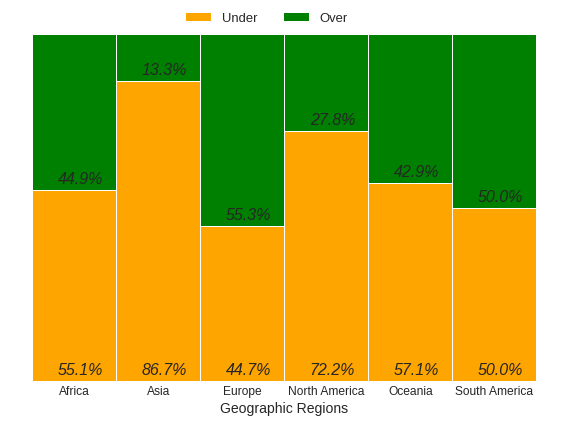

In [13]:
# III
# Summary of world values
%matplotlib inline

plt.style.use('seaborn-darkgrid')
plt.rcParams.update({'ytick.labelleft':'off',
                     'axes.labelsize':14,
                     'xtick.labelsize':12
                    })

r = w_land['continent'].unique()

coli = ['continent', 'ind', 'HpF']
pv = w_land[coli]
pv = pv.groupby(['continent','ind']).count()
pv['%'] = pv.groupby(level=0).apply(lambda x:  100*x / x.sum())

fig= plt.figure(figsize=(8,6))

# Defino los grupos a graficar según 'over' or 'under'
overbar = pv['%'][pv.index.isin(['over'], level=1)].to_list()
underbar = pv['%'][pv.index.isin(['under'], level=1)].to_list()

# Defino parámetros del gráfico
barWidth = 1

# Create over bars
nu = plt.bar(r, underbar, color='orange', edgecolor='white', width=barWidth, label="Under")
no = plt.bar(r, overbar, bottom=underbar, color='green', edgecolor='white', width=barWidth, label="Over" )

plt.box(on=None)

# Custom x axis
plt.xticks(r, w_land['continent'].unique())
plt.tick_params(axis='both', which='both', length=0)
plt.xlabel("Geographic Regions")

# Add a legend
plt.legend(ncol=2, fontsize=13, bbox_to_anchor=(0.3,0.95))

for n in range(6):
    plt.text(nu.patches[n].xy[0]+0.3, nu.patches[n].xy[1]+2, str(round(underbar[n],1))+'%', fontsize=16, fontstyle='oblique')
    plt.text(no.patches[n].xy[0]+0.3, no.patches[n].xy[1]+2, str(round(overbar[n],1))+'%', fontsize=16, fontstyle='oblique')
    
# Y axis in percentage
fmt = '%.0f%%'
yticks = ticker.FormatStrFormatter(fmt)
plt.gca().yaxis.set_major_formatter(yticks)


# To fix the plot size to the layout 
plt.tight_layout()

# Show graphic
plt.savefig('/home/hmdg/Documents/Data_Science/Repos/Lands/images/HpF_bars.png')